# Matches

* Compute generalized match: Coprecessing model VS NR Coprecessing frame 
* The match may be computed in the following ways
  1. Only one modeled HMs at a time 
  2. Only all modeled HMs (2,+-2) and (3,+-3)
  3. Only modeled HMs vs All NR multipole moments 

In [76]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot
import lalsimulation as lalsim

#
from nrutils.analyze.match import match as match_object

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Find a simulation

In [2]:
#
bam_id = 'q8a06t120'
a = scsearch(keyword=bam_id,verbose=True,catalog=calibration_catalog)[0]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a06t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t120dP2_T_96_384)



## Load the NR data

In [5]:

# Load only the select modes of interest
y = gwylm(a,lmax=3,clean=True,verbose=not True,dt=0.5,pad=1000)

# 
lmlist = y.__input_lmlist__

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 3, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.


## Plot sample recomposed waveform at select sky location about source

([<AxesSubplot:ylabel='$r\\,h(t,\\theta,\\phi)/M$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(r\\,h(t,\\theta,\\phi)/M)$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 633.6x760.32 with 4 Axes>)

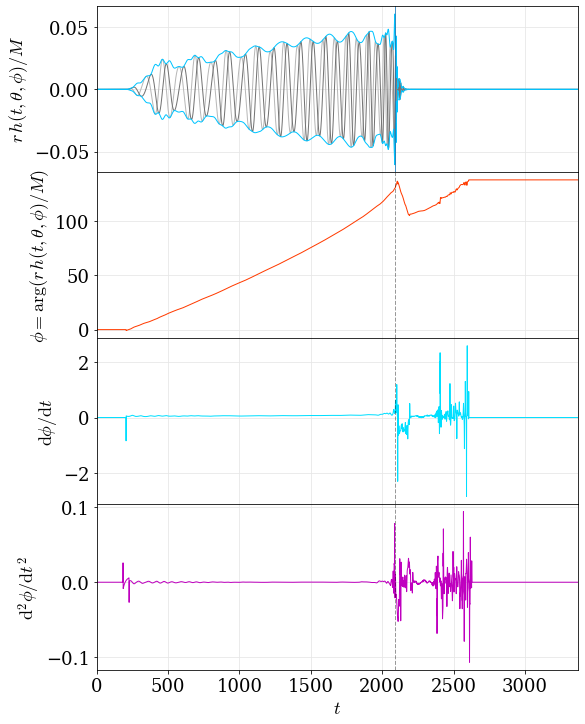

In [9]:

# Define the sky location
theta = pi
phi = 0.0

# Calculate the recoposed waveform using the frequency domain moments 
s = y.recompose( theta, phi, select_lm=lmlist,kind='strain',output_array=not True,domain='freq')

# Plot
s.plot(domain='time')


## Compute model moments

2 2
3 3


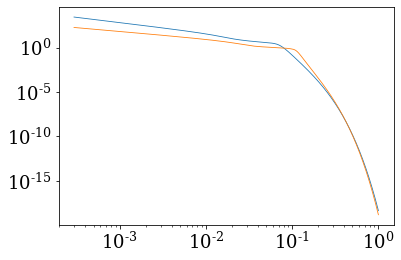

In [161]:

#
modeled_lmlist = [ (2,2), (3,3) ]


#
datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
data_path = datadir+'calibration_data_dict.pickle'
calibration_data_dict = pickle.load( open( data_path, "rb" ) )

#
simname = a.simname

    
#
(metadata,f22,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[2,2][simname]
(metadata,f33,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[3,3][simname]
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z,Mf,Xf = metadata
chi1_vec = array([chi1_x,chi1_y,chi1_z])
chi2_vec = array([chi2_x,chi2_y,chi2_z])

#
df = f22[1]-f22[0]
ff = y.f[y.f>0]# arange( df, 0.2, df )
# ff = arange( min(f22), max(f33)+df, df )

#
tuned_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( ff, modeled_lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand='1-pnr' )

#
for ll,mm in modeled_lmlist:
    
    #
    print(ll,mm)
    hf_lm = tuned_xhm_dict[ll,mm]
    plot( abs(ff), abs(hf_lm) )


#
xscale('log')
yscale('log')

In [255]:
def get_phenom_moment_polarizations( f, modeled_lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand='1-pnr'  ):
    
    '''
    '''
    
    # Get positive frequencies 
    f_pos_mask = f > 0
    f_pos = f[ f_pos_mask ]
    
    # Mirror the positive frequencies for use in determining negative m content
    f_left = -f_pos[::-1]
    
    # Get remaining frequencies 
    f_neg_mask = f < 0
    f_neg = f[ f_neg_mask ]
    
    # Get positive f moments
    l_pos_m_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( f_pos, modeled_lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=option_shorthand )
    
    # Conpute negative f moments from positive ones 
    moments_dict = {}
    for l,m in l_pos_m_moments_dict:
        
        #
        h_right = l_pos_m_moments_dict[l,m]
        
        #
        h_left_template = h_right[::-1].conjugate()
        
        #
        h_left_amp = spline( f_left, abs(h_left_template) )(f_neg)
        h_left_phi = spline( f_left, unwrap(angle(h_left_template)) )(f_neg)
        h_left = h_left_amp * exp( 1j * h_left_phi )
        
        #
        h = zeros_like(f,dtype=complex)
        h[f_neg_mask] = h_left
        h[f_pos_mask] = h_right
        
        #
        h_plus = h
        h_cross = 1j*h
        moments_dict[l, m] = vstack([f,h_plus,h_cross]).T
        
        #
        u =  (-1)**l
        moments_dict[l,-m] = vstack([f, u*h_plus.conj(), u*h_cross.conj()]).T
        
    #
    return moments_dict
    

In [ ]:
def get_phenom_polarizations( moments_dict, theta, phi ):
    
    #
    
    
    

In [252]:
#
all_moments = get_phenom_moment_polarizations( y.f, modeled_lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand='1-pnr'  )

In [253]:
print(all_moments.keys())

dict_keys([(2, 2), (2, -2), (3, 3), (3, -3)])


Text(0.5, 0, '$|f|$')

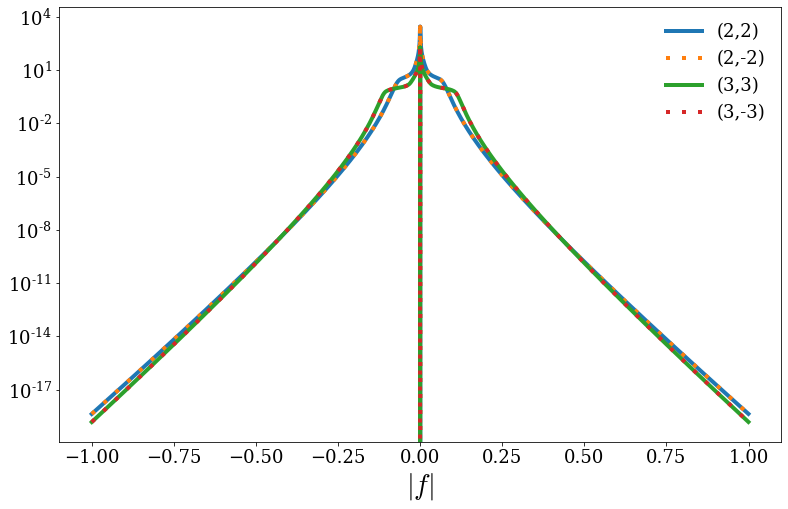

In [254]:

#
figure(figsize=2*figaspect(0.618))

for l,m in all_moments:
    
    #
    f,hp,hx = all_moments[l,m].T
    plot( f.real, abs(hp),label='(%i,%i)'%(l,m), ls=(':' if m<0 else '-'), lw=4 )
        
#
legend()
# xscale('log')
yscale('log')
xlabel('$|f|$',size=28)

In [178]:
print(all_moments)

{(2, 2): array([ 2.63967418e+06+2.63966601e+06j,  6.51204310e+05+1.52987759e+06j,
        8.83129709e+05-5.41534574e+05j, ...,
       -1.77618786e-44-1.78146068e-44j, -1.77630285e-44-1.78126724e-44j,
       -1.77641826e-44-1.78107338e-44j]), (2, -2): array([], dtype=complex128), (3, 3): array([-3.20978716e+04+1.74054249e+03j,  1.32911394e+04+1.21943239e+04j,
       -1.05040336e+04+7.42599839e+03j, ...,
       -1.40663020e-46-7.69041566e-46j, -1.40678751e-46-7.69020337e-46j,
       -1.40694481e-46-7.68999108e-46j]), (3, -3): array([], dtype=complex128)}


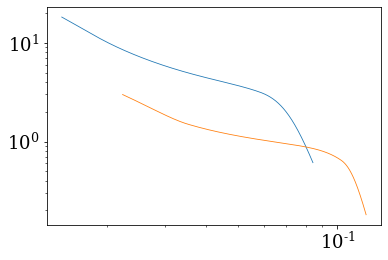

In [45]:

#
modeled_lmlist = [ (2,2), (3,3) ]



datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
data_path = datadir+'calibration_data_dict.pickle'
calibration_data_dict = pickle.load( open( data_path, "rb" ) )

#
simname = a.simname


#
test = {}
for ll,mm in modeled_lmlist:
    
    #
    (metadata,f_,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[ll,mm][simname]
    theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z,Mf,Xf = metadata
    chi1_vec = array([chi1_x,chi1_y,chi1_z])
    chi2_vec = array([chi2_x,chi2_y,chi2_z])

    #
    tuned_xhm_dict_2 = xcp.get_phenomxphm_coprecessing_multipoles( f_,[(ll,mm)], m1, m2, chi1_vec, chi2_vec, option_shorthand='1-pnr' )
    hf_lm = tuned_xhm_dict_2[ll,mm]
    test[ll,mm] = (f_,hf_lm)
    
    #
    plot( f_, abs(hf_lm) )

#
xscale('log')
yscale('log')

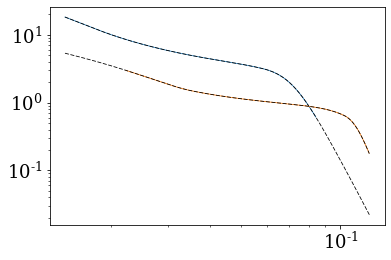

In [46]:
#
for ll,mm in modeled_lmlist:
    
    #
    f_,hf = test[ll,mm]
    plot( f_, abs(hf) )
    plot( ff, abs(tuned_xhm_dict[ll,mm]), c='k', ls='--' )

#
xscale('log')
yscale('log')

## Given model moments, define function to recompose  

In [128]:
# Parameters 
theta = 0   # 0.99*pi/2 # 0.5*pi
phi   = 0
M     = 90  # Solar Masses # 90 Msolar was used in the PE run
D     = 550 # Mpc

# Minimum fmin from NR waveform + 10Hz padding
nr_fmin = physf( y.wstart_pn/(2*pi), M ) + 10.0
fmin    = 20 #
fmax    = 300
df      = physf(y.ylm[0].df,M)

#
print( '>> NR Fmin = %f' % nr_fmin)
print( '>> Using Fmin = %f' % fmin)
print( '>> physical_df = ',df)

>> NR Fmin = 26.337761
>> Using Fmin = 20.000000
>> physical_df =  0.6689911806938937


In [129]:
g = y.tshift(500,apply=False)

([<AxesSubplot:ylabel='$rM\\psi_{22}$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(rM\\psi_{22})$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 633.6x760.32 with 4 Axes>)

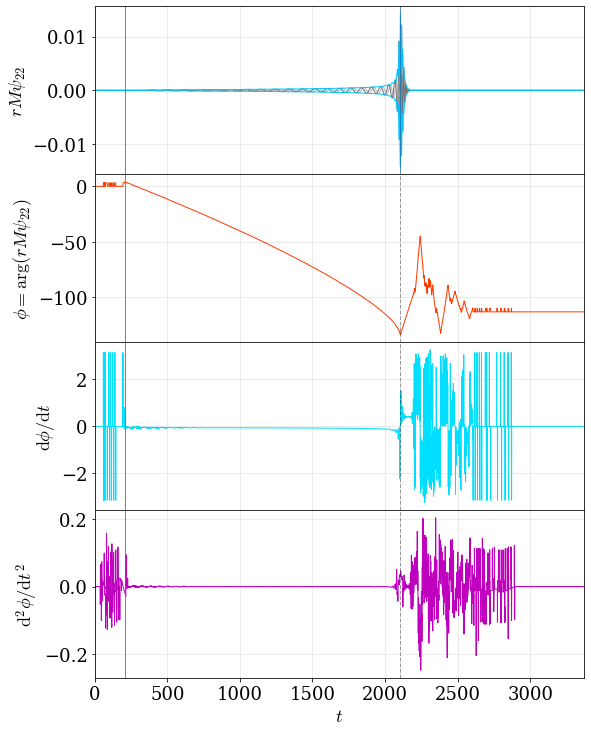

In [130]:
y[2,2]['psi4'].plot()

([<AxesSubplot:ylabel='$rM\\psi_{22}$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(rM\\psi_{22})$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 633.6x760.32 with 4 Axes>)

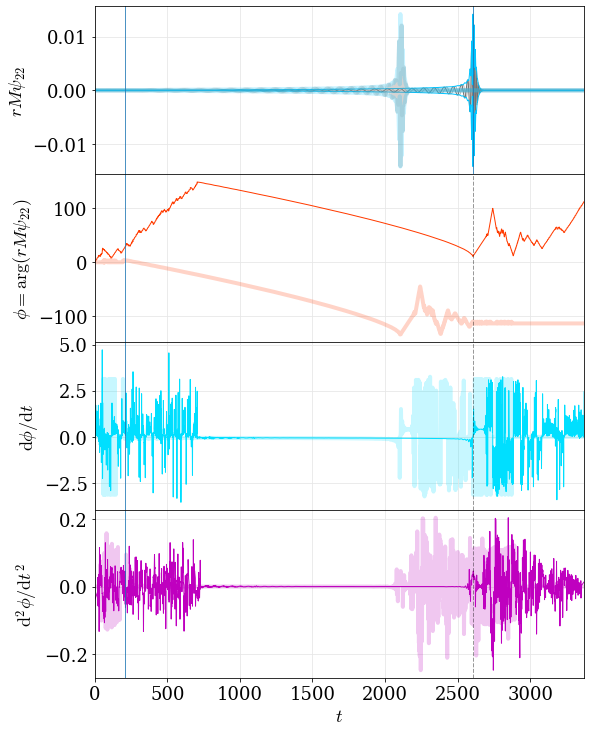

In [131]:
g[2,2]['psi4'].plot(ref_gwf=y[2,2]['psi4'])

In [123]:
#--%--%--%--%--%--%--%--%--%--%--%--#
# Define high-level waveform functions
#--%--%--%--%--%--%--%--%--%--%--%--#

def signal_wfarr_fun( THETA,PHI,LM=None,tshift=0) : 
    # USE ALL NR MODES
    ans = physhf( y.tshift(tshift,apply=False).recompose( THETA,PHI, select_lm=y.__lmlist__,kind='strain',domain='freq').fd_wfarr, M, D ) 
    return ans

def template_wfarr_fun( THETA,PHI,LM=None,tshift=0) : 
    # USE ALL NR MODES
    ans = physhf( y.tshift(tshift,apply=False).recompose( THETA,PHI, select_lm=y.__lmlist__,kind='strain',domain='freq').fd_wfarr, M, D ) 
    return ans


In [124]:
phys_template = signal_wfarr_fun( theta,phi )
phys_signal   = signal_wfarr_fun( theta,phi-pi/2, tshift=500 )

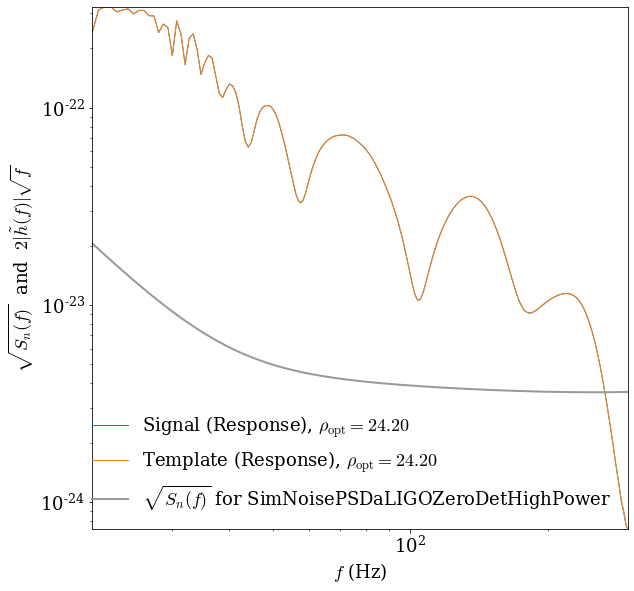

In [125]:
mo = match_object( phys_template, phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
mo.plot();

CPU times: user 9 µs, sys: 17 µs, total: 26 µs
Wall time: 80.1 µs


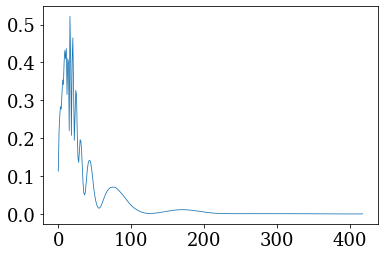

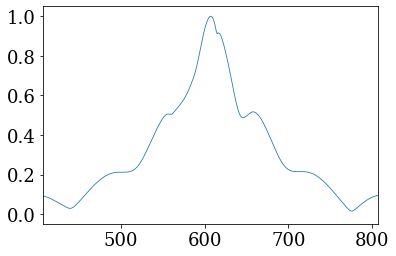


>> Results of intrp_max:
----------------------------------------
    intrp_max 	 = 	 1.000000
intrp_arg_max 	 = 	 607.354724



0.9998018491749149

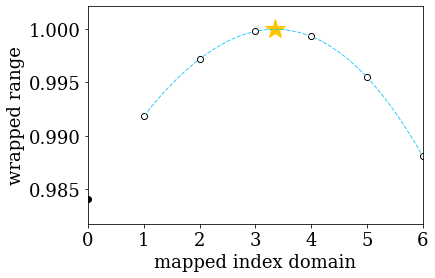

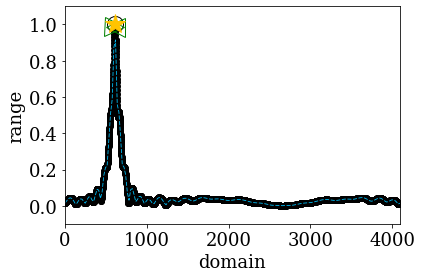

In [132]:
%time
mo.calc_template_pol_optimized_match( plot=True )